# **Face Mask Image Classification using VGG16 (Transfer Learning)**

1.   Anggota 1 : 201810370311432, Kecerdasan Buatan I
2.   Anggota 2 : 201810370311413, Kecerdasan Buatan I



# 1.Inisialisasi Dataset

In [ ]:
#mount storage Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os

train_dir = "/content/gdrive/MyDrive/Colab Notebooks/TUBESAI2021/Dataset/train"
val_dir = "/content/gdrive/MyDrive/Colab Notebooks/TUBESAI2021/Dataset/validation"

mask_train_path = train_dir + '/with_mask'
nonmask_train_path = train_dir + '/without_mask'
mask_val_path = val_dir + '/with_mask'
nonmask_val_path = val_dir + '/without_mask'

mask_len_train = len(os.listdir(mask_train_path))
nonmask_len_train = len(os.listdir(nonmask_train_path))
mask_len_val = len(os.listdir(mask_val_path))
nonmask_len_val = len(os.listdir(nonmask_val_path))

print("Jumlah dataset Training : ", mask_len_train + nonmask_len_train)
print("Jumlah dataset Validasi : ", mask_len_val + nonmask_len_val)
print("Jumlah train kelas Masker : ", mask_len_train)
print("Jumlah train kelas Non Masker : ", nonmask_len_train)
print("Jumlah validasi kelas Masker : ", mask_len_val)
print("Jumlah validasi kelas Non Masker : ", nonmask_len_val)


Jumlah dataset Training :  5000
Jumlah dataset Validasi :  2553
Jumlah train kelas Masker :  2500
Jumlah train kelas Non Masker :  2500
Jumlah validasi kelas Masker :  1225
Jumlah validasi kelas Non Masker :  1328


In [ ]:
#pengecekan file gambar data train
train_mask_fname = os.listdir( mask_train_path )
train_nonmask_fname = os.listdir( nonmask_train_path )

print(train_mask_fname[:10])
print(train_nonmask_fname[:10])

['with_mask_2325.jpg', 'with_mask_2534.jpg', 'with_mask_2805.jpg', 'with_mask_2292.jpg', 'with_mask_1915.jpg', 'with_mask_3088.jpg', 'with_mask_2649.jpg', 'with_mask_2078.jpg', 'with_mask_2198.jpg', 'with_mask_2162.jpg']
['without_mask_3530.jpg', 'without_mask_3430.jpg', 'without_mask_3145.jpg', 'without_mask_2978.jpg', 'without_mask_3326.jpg', 'without_mask_3671.jpg', 'without_mask_3445.jpg', 'without_mask_2850.jpg', 'without_mask_3501.jpg', 'without_mask_3564.jpg']


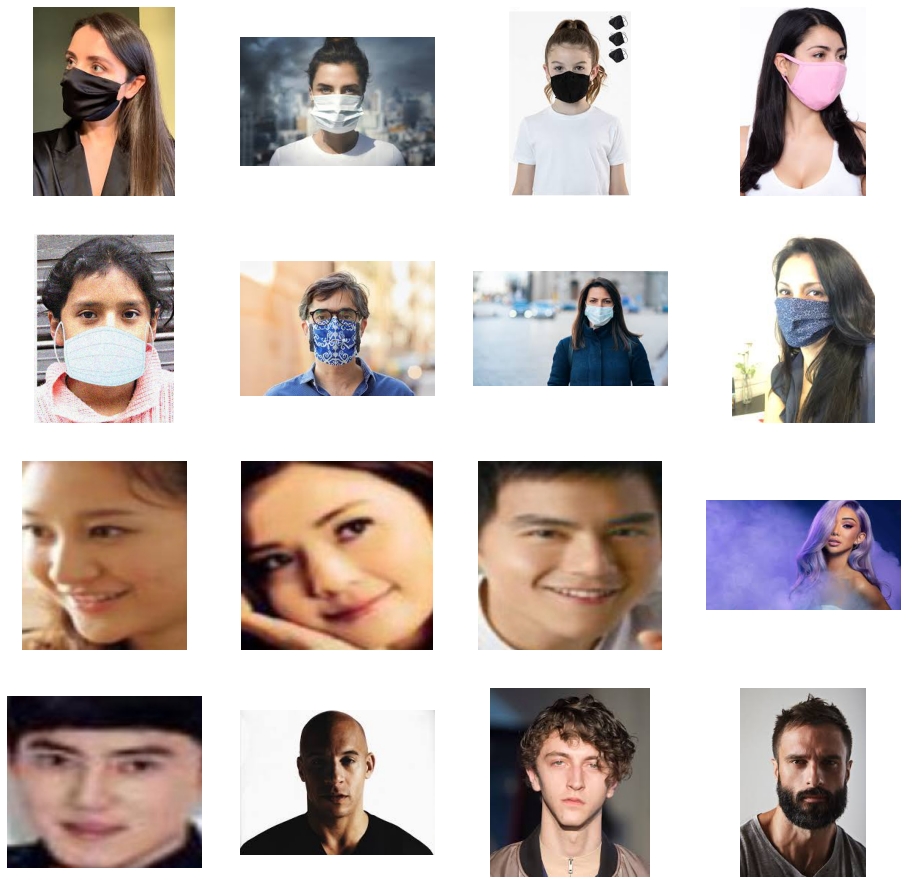

In [ ]:
#menampilkan gambar kedua dataset
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 4
ncols = 4

pict_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pict_index+=8

next_mask_pix = [os.path.join(mask_train_path, fname) 
                for fname in train_mask_fname[ pict_index-8:pict_index] 
               ]

next_nonmask_pix = [os.path.join(nonmask_train_path, fname) 
                for fname in train_nonmask_fname[ pict_index-8:pict_index]
               ]

for i, img_path in enumerate(next_mask_pix + next_nonmask_pix):
  # menyeting subplot
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # tidak menampilkan axes (atau gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Augmentasi Dataset

In [ ]:
'''
Import Library yang dibutuhkan
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten,Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
callbacks = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')        
directory_to_save_best_model_file = '/content/gdrive/MyDrive/Colab Notebooks/TUBESAI2021/model/FacemaskImageClassificationVGG19V2.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 5000 images belonging to 2 classes.
Found 2553 images belonging to 2 classes.


# Build Fit Model and Arcitecture Model

In [ ]:
VGG16_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', #include_top = false , berarti fully connected layer akan dipidah dari arsitektur
                                                 input_tensor=None, input_shape=(224, 224,3))
VGG16_base.trainable = False #pretrained tidak di latih ulang
output = VGG16_base.get_layer(index = -1).output  
output = Flatten()(output)
output = Dense(256,activation = "selu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(1, activation='sigmoid')(output) #menambah layer baru

In [ ]:
model = Model(VGG16_base.input, output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', 
                        metrics =['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=50,validation_data=validation_generator,
                              validation_steps=len(validation_generator)//32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 23s 1s/step - loss: 0.7557 - accuracy: 0.7000 - val_loss: 0.8963 - val_accuracy: 0.6000
Epoch 2/50
7/7 [==============================] - 5s 665ms/step - loss: 0.6416 - accuracy: 0.7929 - val_loss: 0.3927 - val_accuracy: 0.8000
Epoch 3/50
7/7 [==============================] - 4s 583ms/step - loss: 0.5623 - accuracy: 0.7714 - val_loss: 0.3682 - val_accuracy: 0.8125
Epoch 4/50
7/7 [==============================] - 4s 548ms/step - loss: 0.5399 - accuracy: 0.7929 - val_loss: 0.3432 - val_accuracy: 0.8500
Epoch 5/50
7/7 [==============================] - 4s 610ms/step - loss: 0.5116 - accuracy: 0.8429 - val_loss: 0.3869 - val_accuracy: 0.8375
Epoch 6/50
7/7 [==============================] - 4s 573ms/step - loss: 0.3588 - accuracy: 0.8571 - val_loss: 0.4044 - val_accuracy: 0.8375
Epoch 7/50
7/7 [==============================] - 4s 593ms/step - loss: 0.4992 - accuracy: 0.8000 - val_loss: 0.3685 - val_accuracy: 0.8750
Epoch 8/50
7/7 [=================

# Model Evaluation

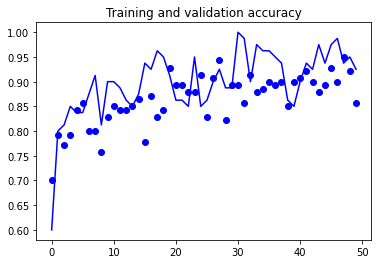

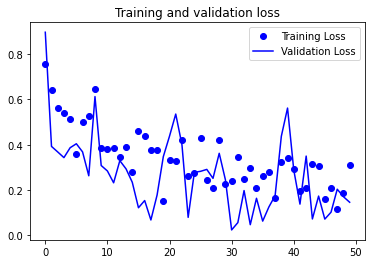

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Analisa Performa Model :

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report, multilabel_confusion_matrix
import seaborn as sns
import numpy as np
sns.set(style='whitegrid')

In [ ]:
from keras.models import load_model
#model.save("/content/gdrive/MyDrive/Colab Notebooks/TUBESAI2021/model/FacemaskImageClassificationVGG19V2.h5")
model_path = '/content/gdrive/MyDrive/Colab Notebooks/TUBESAI2021/model/FacemaskImageClassificationVGG19V2.h5'
model = load_model(model_path)

# Confusion Matrix

Found 1097 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Accuracy  : 0.9690063810391978
Precision : 0.9691425735536335
f1Score : 0.9690227429593155
[[492  13]
 [ 21 571]]


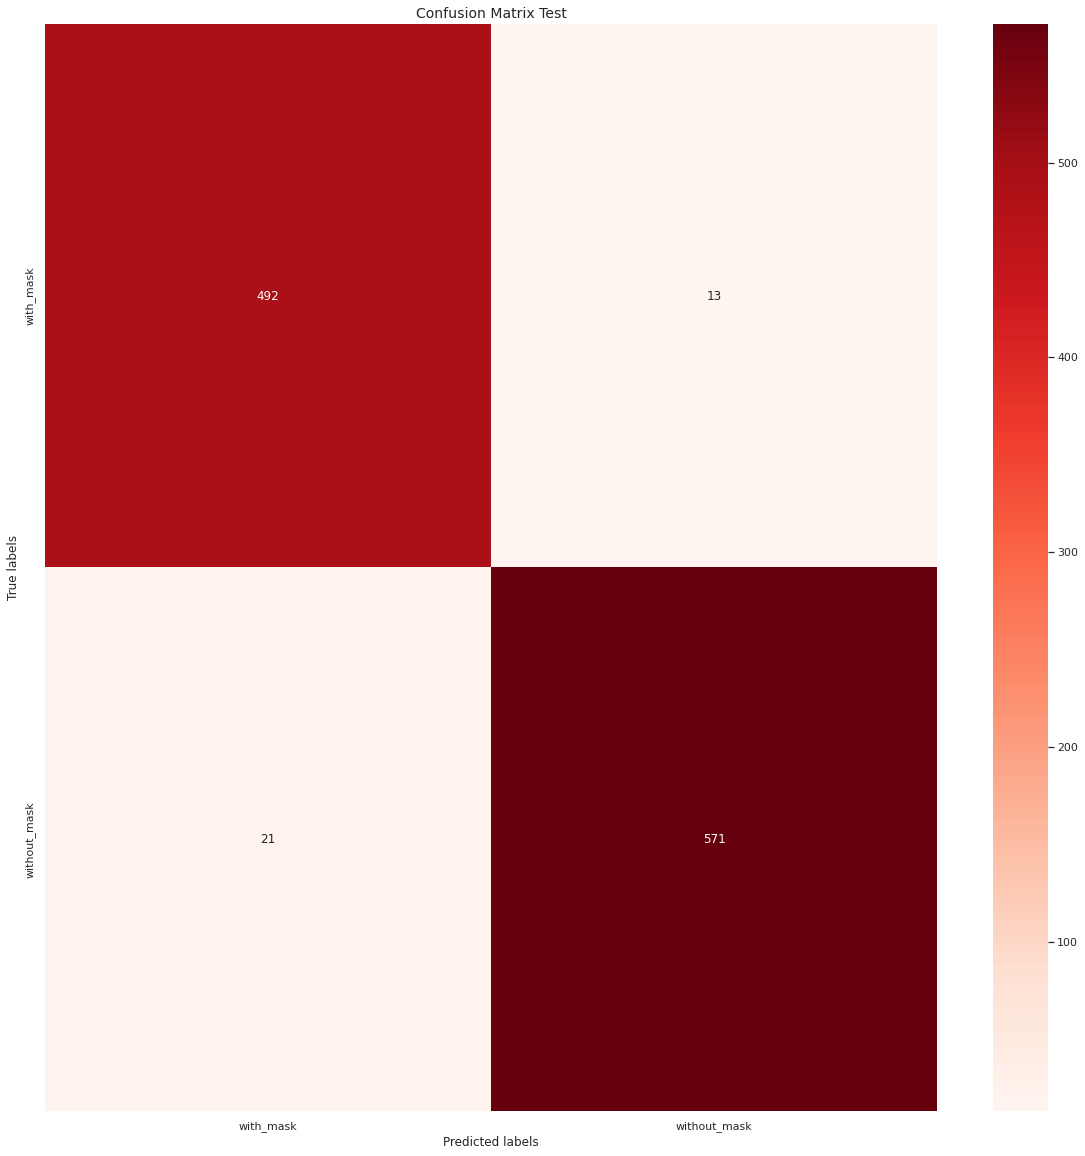

In [ ]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

height=224; width=224
batch_size=20

test_datagen = ImageDataGenerator(rescale=1./255)

TESTING_DIR = '/content/gdrive/MyDrive/Colab Notebooks/TUBESAI2021/Dataset/test'

test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size=batch_size,                                                             
                                                  target_size=(height, width),
                                                  class_mode= None,
                                                  shuffle=False
                                                  )

predictions = model.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(20,20))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Reds)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()


# Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, yPredictions, target_names=class_names))

              precision    recall  f1-score   support

   with_mask       0.96      0.97      0.97       505
without_mask       0.98      0.96      0.97       592

    accuracy                           0.97      1097
   macro avg       0.97      0.97      0.97      1097
weighted avg       0.97      0.97      0.97      1097

